In [1]:
import numpy as np
import pandas as pd
import psycopg2
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import model.dsprev as dp
import time

# Parâmetros da simulação
i = np.arange(0,16,1)         # [0,15]
#t = np.arange(2016,2036,1)    # [2016, 2035]
t = [2015]
s = np.array([1, 3])
c = np.array([1, 2])
k = [41, 42]
#k = [32, # Aposentadoria por invalidez previdenciária 
#     41, # Aposentadoria por idade 
#     42, # Aposentadoria por tempo de serviço previdenciária
#     46, # Aposentadoria por tempo de serviço especial 
#     57]  #Aposentadoria por tempo de serviço de professor

dbtable = 'FATO_AUXILIO_SAMPLE'
#dbtable = 'FATO_AUXILIO'

# Conection parameters
host='tama'
port='5432'
dbname='prevdb'
user='prevdb_user'
pwd='pr3v'

# Track execution time                                                          
start_time = time.time()

# Simulação RGPS

# Variáveis em modelos de Projeção

## Variáveis demográficas

**Pilares** (COSTANZI; ANSILEIRO, 2017):
* **Queda da mortalidade** (inicialmente a infantil)
 * Melhorias em saúde pública, nível educacional, saneamento básico, ...
* **Diminuição na taxa de fecundidade**
 * Retardo no inívio da vida produtiva, contrele da fecundidade, ...
* **Efeitos do padrão moderno de crescimento econômico**
 * Impacto na mobilidade dos indivíduos e na dinâmica do crescimento populacional

### Taxa de Fecundidade

Número médio de filhos que uma mulher teria até o fim do seu período reprodutivo

In [2]:
dt = [[1980, 4.12],
      [2000, 2.39],
      [2030, 1.51],
      [2060, 1.50]]
txnt = pd.DataFrame(dt, columns="ano taxa".split())

Text(0.5, 1.0, 'Projeção da Taxa de natalidade Brasileira até 2060 (IBGE)')

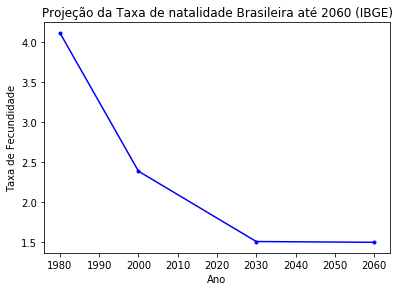

In [3]:
# Create Figure and add set of axes (empty canvas)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot on that set of axes
axes.plot(txnt['ano'], txnt['taxa'], 'b.-')
axes.set_xlabel('Ano')
axes.set_ylabel('Taxa de Fecundidade')
axes.set_title('Projeção da Taxa de natalidade Brasileira até 2060 (IBGE)')

### Taxa de Natalidade

Número de nascidos vivos a cada mil habitantes

### Expectativa de Vida

Aumento resulta em pagamentos de benefícios para idosos por períodos maiores

### Migração

Menor impacto:
* Trabalhadores jovens migrando para outros países
* Entre clienteras Rural e Urbana (regras distintas)

### Taxa de Urbanização

Variável chave, uma vez que as regras de contribuição entre clientelas é bem distinta
* A proporção da população que atua em atividade rual pode ser estimada como $1 - (\text{taxa de urbanização})$

## Variáveis Econômicas

### Reajuste dos Salários

### Inflação

### Taxa de Juros

### Desemprego

### Produtividade

### Formalização

### Crescimento Econômico

## Variáveis Previdenciárias

### Alíqutas de Contribuição

### Probabilidades de entrada no sistema

### Probabilidades de saída do sistema

### Reajuste dos benefícios

### Valores médios dos benefícios

# Modelo de Projeção Oficial do Gov Brasileiro

Utilizado na elaboração das Metas Fiscais das LDOs de 2002 a 2017, possui dois modelos:
* ***Curto prazo***:
 * Ano corrente e três anos subsequentes
 * Utilizado para elaboração do propostas orçamentárias anuais, planos plurianuais e acompanhamento de receitas e despesas do ano corrente
 * Mais simples: menos variáveis, projeção de parâmetros macroeconômicos, não utiliza parâmetros demográficos
 * Não disponível na literatura (PATRICK, 2017)
* ***Longo prazo***:
 * Parte do quito ano seguinte ao ano corrente, até o último ano para o qual são divulgadas as projeções populacionais do IBGE
 * Utilizado para simular o impacto de propostas estruturais
 * Leva em conta variáveis demográficas, econômicas, mercado de trabalho e previdenciárias
 * Equações disponíveis (Anexo IV Metas Fiscais da LDO de 2017)
 
 É importante observar que o modelo não utiliza informações de registros individuais, mas sim informações de [coortes](https://pt.wikipedia.org/wiki/Coorte_(estat%C3%ADstica)) (ou classes anuais) populacionais, sendo tais coortes
por **idade**, **sexo** e **clientela**

Considerações:
* Modelo determinístico
* A LDO de 2017, não descreve quais benefícios são usados no modelo
* A simplicidade do modelo o torna fácil de implementar, mas abstrair todos os benefícios em poucas equações afeta consideravelmente a  recisão dos resultados

In [4]:
print("Parâmetros de indexação e notação geral")
dt = np.array([['i', 'idade', '0, 1, ..., 80'],
               ['t', 'ano', '2012, 2012, ..., 2060'],
               ['s', 'sexo', 'homem ou mulher'],
               ['c', 'clientela', 'urbana ou rual'],
               ['k', 'tipo de benefício', 'aposentadorias, auxílios, pensões, etc']])
idx = pd.DataFrame(dt, columns='Variável Significado Valor'.split(), index=dt[:,0])
idx

Parâmetros de indexação e notação geral


,Variável,Significado,Valor
i,i,idade,"0, 1, ..., 80"
t,t,ano,"2012, 2012, ..., 2060"
s,s,sexo,homem ou mulher
c,c,clientela,urbana ou rual
k,k,tipo de benefício,"aposentadorias, auxílios, pensões, etc"


## Dados e parâmetros utilizados na simulação

| Variável | Valor |
| :--- | ---: |
|Período projetado | 2016-2035 |
|Dados Populacionais | |
| Dados de mercado de Trabalho | |
| Dados de Estoque | |
| Dados de receitas e despesas | |
| Densidade de contribuição | |
| Alíquota de contribuição do Trabalhador | | 
| Alíquota de contribuição do empregador | |
| Crescimento da produtividade do trabalho | |

## Estoque de benefícios

* Para calcular as despesas em determinado ano, inicialmente, é necessário calcular o número de beneficiários neste referido ano, aqui referido como estoque.
* O estoque é calculado pelo método de fluxos, onde a concessão e cessação de benefícios são estimados, e então o estoque de benefícios em um ano é determinado. 
* Os **fluxos de concessão** de benefícios são calculados como:

 $Fe(i,t,s,c,k) = P(i,t,s,c) \times Pe(i,t,s,c,k)$ , onde:
 
 * $Fe$ é o fluxo de entrada nos benefícios tipo $k$, com idade $i$, no ano $t$, do sexo $s$, na clientela $c$
 * $P$ é a população
 * $Pe$ é a **probabilidade de entrada** do benefício específico
 
 $Pe(i,t,s,c,k) = \frac{concessoes(i,t,s,c,k)}{P(i,t,s,c)}$

* Precisa-se ainda da probabilidade se sobrevivência, definida por:
 $Ps (i, t, s) = \frac{P(i+1, t+1, s)}{P(i,t,s)}$

Então, o **estoque de benefícios** pode ser calculado como:

$Eb(i, t, s, c, k) = Eb(i-1, t-1, s, c, k) \times Ps(i,s,c,k) \times Fe(i, t ,s, c, k)$

Finamente, o **estoque total de benefícios** em um dato ano $t$:

$\sum_i \sum_s \sum_c \sum_k Eb(i,t,s,c,k)$

## Despesa com benefícios

Calculada a partir do estoque e do valor médio dos benefícios:

$Db(i,t,s,c,k) =$
$[Eb(i-1, t-1, s, c, k) \times Ps(i,s,c,k) \times Vmb(i,t,s,c,k)] + [Fe(i, t ,s, c, k) \times Vmbe(i,t,s,c,k)]$

Onde:
* $Vmb$ é o valor médio atual do benefício (já concedido) pago
* $Vmbe$ é o valor médio do benefício (projetado) pago

## Receita

Número de contribuintes:

$\sum_i \sum_s \sum_c C(i,t,s,c) =$
$\sum_i \sum_s \sum_c P(i,t,s,c) \times Part(i,t,s,c) \times [1-Desemp(i,t,s,c)] \times d(i,t,s,c)$

Onde:
* $C$ é o estoque de contibuintes
* $P$ é a população
* $Part$ é a taxa de participação na força de trabalho
* $Desemp$ é a taxa de desemprego
* $d$ é a densidade da contribuição (proporção de meses de contribuição do empregado no ano, onde $d=1$ significa 12 meses de contribuição
 
**Valor da receita ($R$) no ano $t$:**

$R_t = \sum_i \sum_s \sum_c C(i,t,s,c) \times [al_{trab} \times \text{Min}(Teto, S_a(i,t,s,c)) + al_{emp} \times S_a(i,t,s,c)]$

Onde:
* $al_{trab}$ é a alíquota de contribuição paga pelo trabalhador
* $al_{emp}$ é a alíquota de contribuição paga pelo empregador
* $Teto$ é o limite de contribuição (maior valor sobre o qual a alíquota pode incidir)
* $S_a$ é o saláro do empregado

# Simulação

In [5]:
# Create simulation dataframe
nvars = 5
ngroups = len(i) * len(t) * len(s) * len(c) * len(k)
dt = np.empty([ngroups, nvars],dtype=int)
row = 0
for idade in i:
    for ano in t:
        for sexo in s:
            for clientela in c:
                for beneficio in k:
                    dt[row, 0] = idade
                    dt[row, 1] = ano
                    dt[row, 2] = sexo
                    dt[row, 3] = clientela
                    dt[row, 4] = beneficio
                    row += 1
df = pd.DataFrame(dt, columns='idade ano sexo clientela beneficio'.split())
df['desc'] = df['idade'].apply(lambda x: dp.get_age_description(x))
df = df[['desc', 'idade', 'sexo', 'clientela', 'beneficio', 'ano']] # reorder columns

In [6]:
df

,desc,idade,sexo,clientela,beneficio,ano
0,Menos de 1 ano,0,1,1,41,2015
1,Menos de 1 ano,0,1,1,42,2015
2,Menos de 1 ano,0,1,2,41,2015
3,Menos de 1 ano,0,1,2,42,2015
4,Menos de 1 ano,0,3,1,41,2015
5,Menos de 1 ano,0,3,1,42,2015
6,Menos de 1 ano,0,3,2,41,2015
7,Menos de 1 ano,0,3,2,42,2015
8,1 a 4 anos,1,1,1,41,2015
9,1 a 4 anos,1,1,1,42,2015


## Estoque de Benefícios

O estoque inicial no ano de 2016 é calculado através da contagem de registros ativos em 2016:

In [7]:
# Connect to an existing database
try:
    conn = psycopg2.connect("host='{}' port={} dbname='{}'user={} password={}"
            .format(host, port, dbname, user, pwd))
except:
        print("Unable to connect to the database")
        
func_time = time.time()

Eb2016 = dp.Eb(conn, dbtable, i, s, c, k)
print("Eb_2016 = {}".format(Eb2016))

df['Eb'] = df.apply(lambda row: dp.Eb(conn, dbtable,
                                      i=[row['idade']], 
                                      s=[row['sexo']],
                                      c=[row['clientela']],
                                      k=[row['beneficio']]), axis=1)
# Close communication with the database                                     
conn.close() 

elapsed_time = (time.time() - func_time) / 60
print("\nExecution time: {0:0.4f} minutes.".format(elapsed_time))

# Pivot table
pveb = df.pivot_table(values='Eb',index='idade',columns=['ano', 'beneficio', 'clientela', 'sexo'])
pveb['desc'] = pveb.index
pveb['desc'] = pveb['desc'].apply(lambda x: dp.get_age_description(x))
print("Estoque de Benefícios")
pveb

Eb_2016 = 12656

Execution time: 0.0184 minutes.
Estoque de Benefícios


ano        2015                                               desc
beneficio    41                     42                            
clientela     1           2          1       2                    
sexo          1     3     1     3    1    3  1  3                 
idade                                                             
0             0     0     0     0    0    0  0  0   Menos de 1 ano
1             0     0     0     0    0    0  0  0       1 a 4 anos
2             0     0     0     0    0    0  0  0       5 a 9 anos
3             0     0     0     0    0    0  0  0     10 a 14 anos
4             0     0     0     0    0    0  0  0     15 a 19 anos
5             0     0     0     0    0    0  0  0     20 a 24 anos
6             0     0     0     0    0    0  0  0     25 a 29 anos
7             0     0     0     0    0    1  0  0     30 a 34 anos
8             0     0     0     0   38    9  0  0     35 a 39 anos
9             0     0     0     0  250  100  1  0     40 a 44 anos
10            0     0     0     0  530  374  0  0     45 a 49 anos
11            0     0     0     0  994  491  6  0     50 a 54 anos
12            0     0     0  2568  827  299  2  0     55 a 59 anos
13            0  1846  1834   332  377   28  3  0     60 a 64 anos
14         1128   194   102    99   21    1  0  0     65 a 69 anos
15           51    69    23    50    8    0  0  0  70 anos ou mais

### População - $P(i,s,c,k)$

A População brasileira foi obitida em:
* 2013, 2014 e 2015: AEPS 2016
* 2016 a 2060: Crescimento segundo taxas anuais disponíveis no site do [IBGE](https://www.ibge.gov.br/apps/populacao/projecao/)

In [17]:
df['P'] = df.apply(lambda row: dp.P(i=[row['idade']], 
                                    s=[row['sexo']],
                                    c=[row['clientela']],
                                    t=[row['ano']]), axis=1)
years = np.arange(2015,2061)
pop = np.zeros(len(years), dtype=int)
cnt = 0
for year in years:
    pop[cnt] = dp.P(t=[year])
    #print(year)
    cnt += 1
#print("População brasileira em 2015: {}". format( \
#    df[df['beneficio'] == 41]['P'].sum()))

Text(0.5, 1.0, 'Projeção da População Brasileira até 2060 (IBGE)')

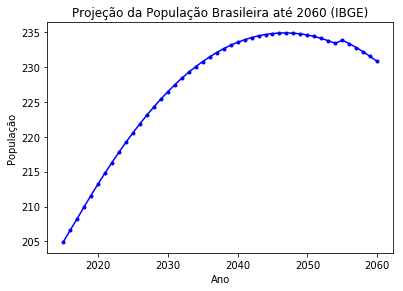

In [20]:
pop/1000000
# Create Figure and add set of axes (empty canvas)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Plot on that set of axes
axes.plot(years, pop/1000000, 'b.-')
axes.set_xlabel('Ano')
axes.set_ylabel('População')
axes.set_title('Projeção da População Brasileira até 2060 (IBGE)')

### Concessões - $concessoes(i,t,s,c,k)$

In [10]:
# Connect to an existing database
try:
    conn = psycopg2.connect("host='{}' port={} dbname='{}'user={} password={}"
            .format(host, port, dbname, user, pwd))
except:
        print("Unable to connect to the database")
#concessoes = dp.concessoes(i,np.arange(1995, 2017),s,c,k,conn, dbtable)
df['concessoes'] = df.apply(lambda row: dp.concessoes(conn, dbtable,
                                      i=[row['idade']],
                                      t=[row['ano']], 
                                      s=[row['sexo']],
                                      c=[row['clientela']],
                                      k=[row['beneficio']]), axis=1)

conn.close()

# Pivot table
pvcs = df.pivot_table(values='concessoes',index='idade',columns=['ano', 'beneficio', 'clientela', 'sexo'])
pvcs['desc'] = pvcs.index
pvcs['desc'] = pvcs['desc'].apply(lambda x: dp.get_age_description(x))
pvcs

ano       2015                                        desc
beneficio   41               42                           
clientela    1        2       1      2                    
sexo         1    3   1   3   1   3  1  3                 
idade                                                     
0            0    0   0   0   0   0  0  0   Menos de 1 ano
1            0    0   0   0   0   0  0  0       1 a 4 anos
2            0    0   0   0   0   0  0  0       5 a 9 anos
3            0    0   0   0   0   0  0  0     10 a 14 anos
4            0    0   0   0   0   0  0  0     15 a 19 anos
5            0    0   0   0   0   0  0  0     20 a 24 anos
6            0    0   0   0   0   0  0  0     25 a 29 anos
7            0    0   0   0   0   0  0  0     30 a 34 anos
8            0    0   0   0   0   0  0  0     35 a 39 anos
9            0    0   0   0   0   1  0  0     40 a 44 anos
10           0    0   0   0  10  14  0  0     45 a 49 anos
11           0    0   0   0  72  47  2  0     50 a 54 anos
12           0    0   0  84  78  38  1  0     55 a 59 anos
13           0  172  64  10  44   2  0  0     60 a 64 anos
14         121   18   5   3   4   0  0  0     65 a 69 anos
15           3    3   0   4   2   0  0  0  70 anos ou mais

### Probabilidade de Entrada - $Pe(i, t, s, c, k)$

$Pe(i,t,s,c,k) = \frac{concessoes(i,t,s,c,k)}{P(i,t,s,c)}$

Calculada para o ano de referência de 2016

In [11]:
# Connect to an existing database
try:
    conn = psycopg2.connect("host='{}' port={} dbname='{}'user={} password={}"
            .format(host, port, dbname, user, pwd))
except:
        print("Unable to connect to the database")

df['Pe'] = df.apply(lambda row: row['concessoes'] / row['P'], axis=1)
conn.close()

df[df['Pe']!=0]
#pop2016 = pop[pop['Ano'] == 2016]['Brasil'].iloc[0]
#Pe = concessoes2016 / pop2016
#print("Pe = concessões/ população = {}/{} = {}".format(concessoes2016, pop2016, Pe))

,desc,idade,sexo,clientela,beneficio,ano,Eb,P,concessoes,Pe
77,40 a 44 anos,9,3,1,42,2015,100,6581158,1,1.519489e-07
81,45 a 49 anos,10,1,1,42,2015,530,5432777,10,1.840679e-06
85,45 a 49 anos,10,3,1,42,2015,374,6181660,14,2.264764e-06
89,50 a 54 anos,11,1,1,42,2015,994,5112252,72,1.408381e-05
91,50 a 54 anos,11,1,2,42,2015,6,960799,2,2.081601e-06
93,50 a 54 anos,11,3,1,42,2015,491,6018642,47,7.809071e-06
97,55 a 59 anos,12,1,1,42,2015,827,4212576,78,1.851599e-05
99,55 a 59 anos,12,1,2,42,2015,2,826136,1,1.210454e-06
101,55 a 59 anos,12,3,1,42,2015,299,5128314,38,7.409843e-06
102,55 a 59 anos,12,3,2,41,2015,2568,735210,84,1.142531e-04


### Fluxo de Entrada - $Fe(i,t,s,c,k)$

* Os **fluxos de concessão** de benefícios são calculados como:

 $Fe(i,t,s,c,k) = P(i,t,s,c) \times Pe(i,t,s,c,k)$ , onde:
 
 * $Fe$ é o fluxo de entrada nos benefícios tipo $k$, com idade $i$, no ano $t$, do sexo $s$, na clientela $c$
 * $P$ é a população
 * $Pe$ é a **probabilidade de entrada** do benefício específico

In [12]:
df['Fe'] = df.apply(lambda row: 0 if row['Pe'] == 0 else row['P']*row['Pe'], axis=1)
df[df['Fe'] != 0]

,desc,idade,sexo,clientela,beneficio,ano,Eb,P,concessoes,Pe,Fe
77,40 a 44 anos,9,3,1,42,2015,100,6581158,1,1.519489e-07,1.0
81,45 a 49 anos,10,1,1,42,2015,530,5432777,10,1.840679e-06,10.0
85,45 a 49 anos,10,3,1,42,2015,374,6181660,14,2.264764e-06,14.0
89,50 a 54 anos,11,1,1,42,2015,994,5112252,72,1.408381e-05,72.0
91,50 a 54 anos,11,1,2,42,2015,6,960799,2,2.081601e-06,2.0
93,50 a 54 anos,11,3,1,42,2015,491,6018642,47,7.809071e-06,47.0
97,55 a 59 anos,12,1,1,42,2015,827,4212576,78,1.851599e-05,78.0
99,55 a 59 anos,12,1,2,42,2015,2,826136,1,1.210454e-06,1.0
101,55 a 59 anos,12,3,1,42,2015,299,5128314,38,7.409843e-06,38.0
102,55 a 59 anos,12,3,2,41,2015,2568,735210,84,1.142531e-04,84.0


### Probabilidade de Sobrevivência - $Ps(i,t,s)$

* Definida por:
 $Ps (i, t, s) = \frac{P(i+1, t+1, s)}{P(i,t,s)}$

In [13]:
dp.P(t=[2060])

230812121

In [14]:
#df.apply(lambda row: print(row), axis=1)
df

,desc,idade,sexo,clientela,beneficio,ano,Eb,P,concessoes,Pe,Fe
0,Menos de 1 ano,0,1,1,41,2015,0,1088181,0,0.000000e+00,0.0
1,Menos de 1 ano,0,1,1,42,2015,0,1088181,0,0.000000e+00,0.0
2,Menos de 1 ano,0,1,2,41,2015,0,207031,0,0.000000e+00,0.0
3,Menos de 1 ano,0,1,2,42,2015,0,207031,0,0.000000e+00,0.0
4,Menos de 1 ano,0,3,1,41,2015,0,1011475,0,0.000000e+00,0.0
5,Menos de 1 ano,0,3,1,42,2015,0,1011475,0,0.000000e+00,0.0
6,Menos de 1 ano,0,3,2,41,2015,0,207325,0,0.000000e+00,0.0
7,Menos de 1 ano,0,3,2,42,2015,0,207325,0,0.000000e+00,0.0
8,1 a 4 anos,1,1,1,41,2015,0,4491543,0,0.000000e+00,0.0
9,1 a 4 anos,1,1,1,42,2015,0,4491543,0,0.000000e+00,0.0


### Estoque de Benefícios - $Eb(i,t,s,c,k)$

# Ofensores / Próximos passos

* **P()**
 * Dados agregados no AEPS
 * Dificuldade para cálculo de Ps()
* **Eb() para todos os anos da série histórica**
 * Microdados possuem estoque em 2016, utilizar dados do anuário para outros anos?
 * Não é possível calcular estoque em outros anos a partir dos microdados, uma vez que não temos a data de cessação do benefício

# Referências

* [Dados Abertos Previdência Social](http://www.previdencia.gov.br/dados-abertos/dados-abertos-previdencia-social/)
 * [Anuário estatístico da Previdência Social em 2015](http://www.previdencia.gov.br/wp-content/uploads/2015/08/AEPS-2015-FINAL.pdf)
 * [Anuário estatístico da Previdência Social em 2016](http://sa.previdencia.gov.br/site/2018/08/aeps2016.pdf)
   * [Principais resultados](http://sa.previdencia.gov.br/site/2018/02/Apresenta%C3%A7%C3%A3o-Alexandre-Ziole-AEPS-2016-003.pdf)
* [CPIPREV](https://legis.senado.leg.br/comissoes/docsRecCPI?codcol=2093 "DOC090 / Midia 018 and DOC097 e Midia 019") 
* [Wiki do projeto](https://prev.andrepereira.eng.br) 
* IBGE
 * [IBGE, contagem da População 2007](https://ww2.ibge.gov.br/home/estatistica/populacao/contagem2007/contagem.pdf)
 * [IBGE, Estimativas de população](http://dados.gov.br/dataset/xf-estimativas-de-populacao)
 * [IBGE, Projeção da População](https://www.ibge.gov.br/apps/populacao/projecao/)

In [15]:
# Print out elapsed time                                                        
elapsed_time = (time.time() - start_time) / 60                                  
print("\nExecution time: {0:0.4f} minutes.".format(elapsed_time))


Execution time: 0.0619 minutes.
